# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [206]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [207]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [208]:
# Rank the words existing, to figure out the words for stop-word.
from sklearn.feature_extraction.text import CountVectorizer 
movie_data = pd.read_csv('moviereviews_train.tsv', sep='\t')
texts = movie_data['review']
vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
sorted(words_freq, key = lambda x: x[1], reverse=True)

[('the', 336749),
 ('and', 164140),
 ('of', 145864),
 ('to', 135724),
 ('is', 107332),
 ('br', 101871),
 ('it', 96467),
 ('in', 93976),
 ('this', 76007),
 ('that', 73286),
 ('was', 48209),
 ('as', 46935),
 ('for', 44345),
 ('with', 44130),
 ('movie', 44047),
 ('but', 42623),
 ('film', 40159),
 ('you', 34267),
 ('on', 34202),
 ('not', 30632),
 ('he', 30155),
 ('are', 29438),
 ('his', 29376),
 ('have', 27731),
 ('be', 26957),
 ('one', 26795),
 ('all', 23985),
 ('at', 23516),
 ('they', 22915),
 ('by', 22548),
 ('an', 21564),
 ('who', 21441),
 ('so', 20614),
 ('from', 20499),
 ('like', 20281),
 ('there', 18865),
 ('her', 18424),
 ('or', 18007),
 ('just', 17774),
 ('about', 17375),
 ('out', 17113),
 ('if', 16809),
 ('has', 16791),
 ('what', 16168),
 ('some', 15749),
 ('good', 15147),
 ('can', 14677),
 ('more', 14252),
 ('she', 14228),
 ('when', 14184),
 ('very', 14067),
 ('up', 13293),
 ('time', 12727),
 ('no', 12716),
 ('even', 12655),
 ('my', 12504),
 ('would', 12436),
 ('which', 12051),


In [209]:
# Making Stop_words set to be applied
freqwords=sorted(words_freq, key = lambda x: x[1], reverse=True)
most_freqwords=freqwords[:10]
most_freqwords


[('the', 336749),
 ('and', 164140),
 ('of', 145864),
 ('to', 135724),
 ('is', 107332),
 ('br', 101871),
 ('it', 96467),
 ('in', 93976),
 ('this', 76007),
 ('that', 73286)]

In [210]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
#     n_features 2**17 ->2**14 to avoid larger coefficient dimensions in linear learners
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 14, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
#     movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
#     word counting was deleted (no significant impact presumably)
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
       # Negative reviews tend to have the word 'waste' more than the favorable reviews.
    # This specific word is added to the feature set.
    movie_data['waste_count'] = movie_data['review'].str.count("waste")

    X_quant_features = movie_data[["punc_count","waste_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [211]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=44)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 16384)
Look at a few rows of the new quantitative features: 
   punc_count  waste_count
0          20            0
1          16            0
2          20            0
3           8            0
4           9         

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [212]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9987, 'Neg': 10013, 'TP': 4877, 'TN': 4926, 'FP': 5087, 'FN': 5110, 'Accuracy': 0.49015, 'Precision': 0.48946206342834203, 'Recall': 0.4883348352858716, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [213]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9987, 'Neg': 10013, 'TP': 9987, 'TN': 10013, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [214]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log',alpha=0.001)
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9987, 'Neg': 10013, 'TP': 9987, 'TN': 10013, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [215]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB(alpha=15.0)
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9987, 'Neg': 10013, 'TP': 8909, 'TN': 9203, 'FP': 810, 'FN': 1078, 'Accuracy': 0.9056, 'Precision': 0.9166580923963371, 'Recall': 0.8920596775808551, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [216]:
# alpha 15->5

In [217]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron',alpha=5)
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9987, 'Neg': 10013, 'TP': 9972, 'TN': 9959, 'FP': 54, 'FN': 15, 'Accuracy': 0.99655, 'Precision': 0.9946140035906643, 'Recall': 0.9984980474617002, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [218]:
# alpha 25->15, tol 0.0001->0.001 0.49..->0.49

In [219]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=15,tol=0.001)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9987, 'Neg': 10013, 'TP': 9975, 'TN': 10000, 'FP': 13, 'FN': 12, 'Accuracy': 0.99875, 'Precision': 0.9986984381257509, 'Recall': 0.9987984379693602, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [220]:
# n_estimators - default value is 100. However, for the sake of clearer boundry,
# 95 is tried this time.

# max_features value: by reducing the number of features selection, give a greater variation
# among the trees generated. Default value is set 'auto'.If the change is dramatically big, it is going to be more than just avoiding overfit
# Current auto value is sqrt (n_features). therefore, sqrt(131075)=362.x
# For now, give a shot of 300.->400


In [221]:
# nesti 80, max feat , 300 / 0.546 -> nesti 60, max feat 400 /0.569 420/0.572

In [222]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(n_estimators=60,max_depth=2,random_state=0, max_features =420)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 9987, 'Neg': 10013, 'TP': 8520, 'TN': 7147, 'FP': 2866, 'FN': 1467, 'Accuracy': 0.78335, 'Precision': 0.7482873704549446, 'Recall': 0.8531090417542806, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

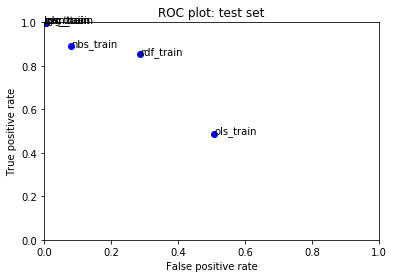

In [223]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [224]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [225]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
122
About twenty minutes into this movie, I was already bored. Quite simply, these characters were fairly dull. Occasionally, something enjoyable would happen, but then things would slow down again. Fortunately, my patience was eventually rewarded, and the ending to this movie wasn't bad at all. However, it was by no means good enough to justify sitting through the first ninety minutes. So, I would say that the movie was mediocre overall, and considering all of the talent in the cast, I'd call this a disappointment.
* * * * * * * * * 
133
Bored Londoners Henry Kendall and Joan Barry (as Fred and Emily Hill) receive an advance on an inheritance. They use the money go traveling. Their lives become more exciting as they begin relationships with exotic Betty Amann (for Mr. Kendall) and lonely Percy Marmont (for Ms. Barry). But, they remain as boring as they were before. Arguably bored director Alfred Hitchcock tries to liven up the well-titled (as quoted in the

1949
\Ghost of Dragstrip Hollow\" appears to take place in a spotless netherworld, an era long gone by, where the biggest sin a kid could commit would be in defying the law and getting a traffic ticket. It opens with a young female auto fanatic getting the business from her arch rival, who pressures her into a car race. That's about it for the drag-racing--this B-flick is mostly concerned with rock 'n roll, man! The folks at American International were obviously fond of decent, square teens who liked to party and yet didn't mind an adult chaperone. There are a few amusing double entendres and fruity exchanges (Necking Kid: \"We thought we'd come out for some fresh air\"...Dad: \"Where did you think you'd find it, down her throat?\"), but the ghost is a little late in arriving. Brief at 65 minutes, the movie cheats us with a climactic car race that actually takes place off-screen and a pre-\"Scooby Doo\"-styled unmasking which makes no sense. However, for nostalgia buffs, some mindless 

3639
I once promised never to walk out of any film ( a personal policy that made me suffer through the most different kinds of dreck, such as Rambo 3, Baise Moi, Deep Impact) - but Mr. Seidl almost succeeded. Hundstage was a truly awful experience. Anyone who sees this movie will think that Austrians are a miserable, pathetic bunch of retards. It shows a world where love and humanity don't exist, a world where people humiliate each other only for one reason - to distract from their own miserable existence. By choosing a documentary-like style with non-professional actors (most of them look like straight from the imagination of Austrian shock-cartoonist Deix) director Seidl wants to make us believe that this is real life in Austrian (European? Western?) suburbs. The viewer is confronted with depictions of sex orgies, violence against women and handicapped people, madness and degradation. But this isn't social criticism. This is just pure shock without any aesthetic value. Instead you ge

6000
Avoid this crap at all costs. Bad script, bad directing, bad acting, bad editing, bad sound, and bad music. Get the idea? This movie tries to be western flavored, it's not. It tries to be hard core violent, it's not. It tries to present a fresh look at an old genre, it doesn't. The actors try there best, and my heart goes out to them. But with such inane material to work with it's hard to make something shine. To me this has all of the looks of a \fresh outta film school gonna set the world on fire\" first attempt. Freshmen film makers often bite off more that they, or their budget, can chew. The best thing they can do is to take a few steps back, reassess what is possible, and work within their limited budget the next time out."
* * * * * * * * * 
6021
Last week, I took a look at the weekly Nielsen ratings, and there was Veronica Mars, supposedly \the best show you're not watching\".<br /><br />Well, they're right that you're not watching it. It aired twice and was ranked 147 and

8354
If I could give this film a real rating, it would likely be in the minus numbers. While I respect the fact that somebody has to keep making these terrible \horror\" films, seriously, people, buying a ticket for this film is a waste of money you could be spending on something far more worth your time.<br /><br />Despite it being a horror film, there is nothing scary about it, unless the idea of seeing how many horror cliché's you can fit in one movie scares you. If the rating had been higher, it probably would have made for a better film in the long run.<br /><br />Whoever made this version of \"Prom Night\", you screwed up. The actors could probably have done a decent job if it weren't for the questionable scripting. This was a terrible waste of a cinema trip. I'd sooner go and see \"One Missed Call\" again, at least that had some plot."
* * * * * * * * * 
8497
This is possibly one of the worst giant killer animal movies I have ever seen. It follows the typical premise of a labora

11094
I can't believe I wasted my time with this movie. I couldn't even call it a movie. It was so bad with nothing to recommend it. <br /><br />I like low budget movies and weird flicks but this one had me bored to death. Badly made and bad acting ruined it from being curious. You have to wonder what these people were thinking when they spent money to produce this movie. I wonder what I was thinking watching it to the end. I recommend this movie to no one. How did they release this? Was there an audience who likes this kind of movie? There must be because you can find this at almost any video store. But why?<br /><br />Deserves to be forgotten.<br /><br />If you like bad movies then this is for you.
* * * * * * * * * 
11143
Disappointing and undeniably dull true-crime movie that has poorly cast character actor Jeremy Renner languidly mumbling his way through the title role of Jeffrey Dahmer, who was easily one of the last century's most recognizable degenerates/serial killers. Release

13825
Did HeidiJean really see this movie? A great Christmas movie? Not even close. Dull, bland and completely lacking in imagination and heart. I kept watching this movie wondering who the hell thought that Carly Pope could play the lead in this movie! The woman has no detectable personality and gives a completely lackluster performance. Baransky was great as usual and provided the only modicum of interesting the whole thing. Probably her involvement was the only reason this project was green lighted to begin with. Maybe I'm expecting too much for a Lifetime movie played 15 days from Christmas but I sat through this thing thinking that with a different director and a recasting JJ with an actress that at least could elicit sympathy this could have been quite a cute little movie.
* * * * * * * * * 
13867
The various nudity scenes that other reviewers referred to are poorly done and a body double was obviously used. If Ms. Pacula was reluctant to do the scenes herself perhaps she should 

15574
I've tried to like this film, really. In watching it, all I can think is, \This guy gives me the creeps, I would have gotten a restraining order\". It also calls out CODEPENDENCE in capital letters. Was this really the conversation before making the movie? \"Let's make a film that puts two chronically depressed, socially inept people into a relationship which deepens their isolation and encourages them to complain about how bad their lives are!\" From what I've seen in life is that the last thing on earth we find attractive in a potential mate is constant self-pity. <br /><br />The mood of the movie is distinctly 80-ish; brooding and slow. Don't get me wrong, the film has its moments, just very few of them."
* * * * * * * * * 
15592
I went to see this a few days ago, and it's hard to forget that film...for the wrong reasons. This film is supposed to be funny, it's not, not a single laugh in the theatre( perhaps for josé garcia and gérard Depardieu ), and it's boring, boring, bori

16999
Why oh why can't anyone make a decent film out of a legendary tale? This is the second adaptation of \Beowulf\" I've been disappointed with in a year. But I have to say, the previous version (\"Beowulf & Grendel\", starring Gerald Butler) was far superior to this. That one was only a little disappointing. This one is a mess!!! <br /><br />What bugged me most? Was it the useless plot elements they added in for no particular reason (Human sacrifices? Pointless love interest?), or the bad CGI, or the inconsistency of the characters or the uninspired acting? Even worse was the way they made beautiful Marina Sirtis look so horrible!!! And lets not even talk about that ridiculous crossbow? <br /><br />And why did they continually remind us that Beowulf had the strength of 30 men, and yet he never showed the slightest sign of such strength throughout the entire film. He was tossed around by both monsters he fought, relying on his sidekicks to save his bacon. Even when he slugged the arr

19225
The Haunting, if you have seen the original, you know a great ghost story, it's perfection on film. It's a haunting tale of 4 people who go into a haunted house and with the simple trick of sound and movements, it terrified people. It still remains effective to this day if you appreciate film. So when The Haunting was remade in 1999, a lot of people pretty much had the same reaction \WHAT? WHY? WHAT THE\" But in my opinion if a remake is respectful enough and just wants to reinvent the story for the newer generation, I'm pretty cool with it. This is definitely not the case, this is just a disrespectful boring shame that will waste your time and I guarantee will deliver no scares pfft! PG-13, what where they thinking? Not much apparently.<br /><br />When her mother dies and her sister evicts her, Nell receives a phone call, telling her about an ad for an insomnia study run by Doctor David Marrow at Hill House, a secluded manor. Upon arrival, Nell meets Mr. and Mrs. Dudley, a str

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [226]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2513, 'Neg': 2487, 'TP': 1235, 'TN': 1275, 'FP': 1212, 'FN': 1278, 'Accuracy': 0.502, 'Precision': 0.5046996322026972, 'Recall': 0.49144448865897333, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [227]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2513, 'Neg': 2487, 'TP': 2083, 'TN': 2045, 'FP': 442, 'FN': 430, 'Accuracy': 0.8256, 'Precision': 0.8249504950495049, 'Recall': 0.8288897731794668, 'desc': 'svm_test'}


### MODEL: logistic regression

In [245]:
# According to this value and graph projection, lgs has the highest performance
# But the final mean value, rdf is better.

In [228]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2513, 'Neg': 2487, 'TP': 2111, 'TN': 2052, 'FP': 435, 'FN': 402, 'Accuracy': 0.8326, 'Precision': 0.8291437549096622, 'Recall': 0.8400318344608039, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [229]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2513, 'Neg': 2487, 'TP': 1958, 'TN': 2012, 'FP': 475, 'FN': 555, 'Accuracy': 0.794, 'Precision': 0.8047677764077271, 'Recall': 0.7791484281734978, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [230]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2513, 'Neg': 2487, 'TP': 2110, 'TN': 2013, 'FP': 474, 'FN': 403, 'Accuracy': 0.8246, 'Precision': 0.81656346749226, 'Recall': 0.8396339037007561, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [231]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2513, 'Neg': 2487, 'TP': 1743, 'TN': 1708, 'FP': 779, 'FN': 770, 'Accuracy': 0.6902, 'Precision': 0.6911181601903251, 'Recall': 0.6935933147632312, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [232]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2513, 'Neg': 2487, 'TP': 2102, 'TN': 1734, 'FP': 753, 'FN': 411, 'Accuracy': 0.7672, 'Precision': 0.7362521891418564, 'Recall': 0.8364504576203741, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

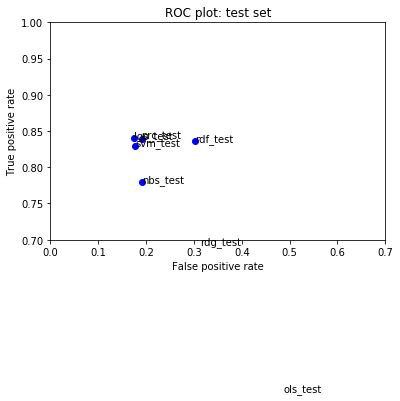

In [244]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 0.7, 0.7, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [234]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=44, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 16384)
Look at a few rows of the new quantitative features: 
   punc_count  waste_count
0           5            0
1          15            1
2          18            0
3           5            0
4           8            0
5          20            0
6          18            0
7          22            0
8           3            0
9          14        

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [246]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = lgs.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.48164


In [247]:
raw_data.head()

,id,review,punc_count,waste_count
0,12311_10,Naturally in a film who's main themes are of m...,5,0
1,8348_2,This movie is a disaster within a disaster fil...,15,1
2,5828_4,"All in all, this is a movie for kids. We saw i...",18,0
3,7186_2,Afraid of the Dark left me with the impression...,5,0
4,12128_7,A very accurate depiction of small time mob li...,8,0


In [248]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,0
4,12128_7,1


In [249]:
my_submission.shape

(25000, 2)

In [250]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('./sample_submissions/moviereviews_sample_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation